In [39]:
import sys
sys.path.append('../')  # Add the parent directory of your package to sys.path

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
import astropy.units as u

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sphot.data import (CutoutData, MultiBandCutout, 
                        load_h5data, crop_in, get_data_annulus)
from sphot.plotting import astroplot, plot_sersicfit_result
from sphot.fitting import SphotModel, ModelFitter

/Users/sterling/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load sample data

In [40]:
folder_PSF = '../sample_data/'
folder_cutouts = '../sample_data/'
filters = ['F555W','F814W','F090W','F150W','F160W','F277W']

pix_scale = 0.03 * u.arcsec
fwhm_dict = dict(
    # https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-6-uvis-optical-performance
    # https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-6-ir-optical-performance
    # https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
    F555W = 0.067 * u.arcsec / pix_scale,
    F814W = 0.074 * u.arcsec / pix_scale,
    F090W = 0.033 * u.arcsec / pix_scale,
    F150W = 0.050 * u.arcsec / pix_scale,
    F160W = 0.151 * u.arcsec / pix_scale,
    F277W = 0.092 * u.arcsec / pix_scale,
)

11.034148105929498


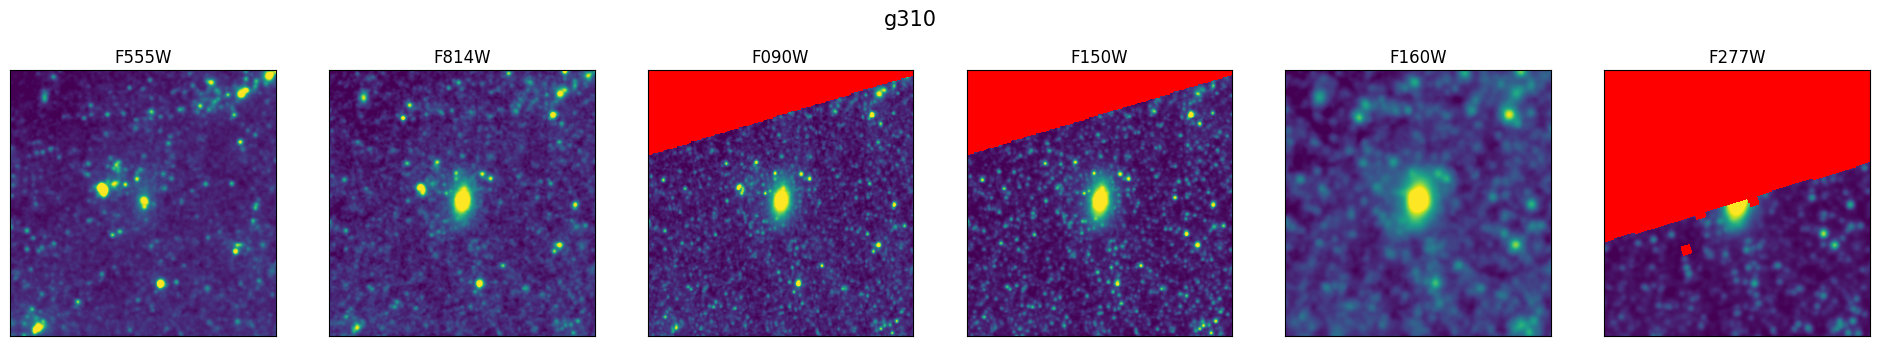

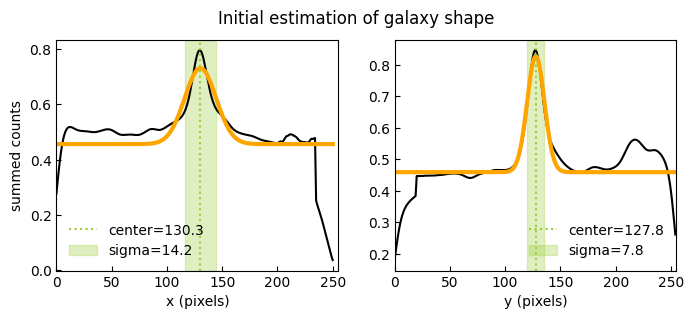

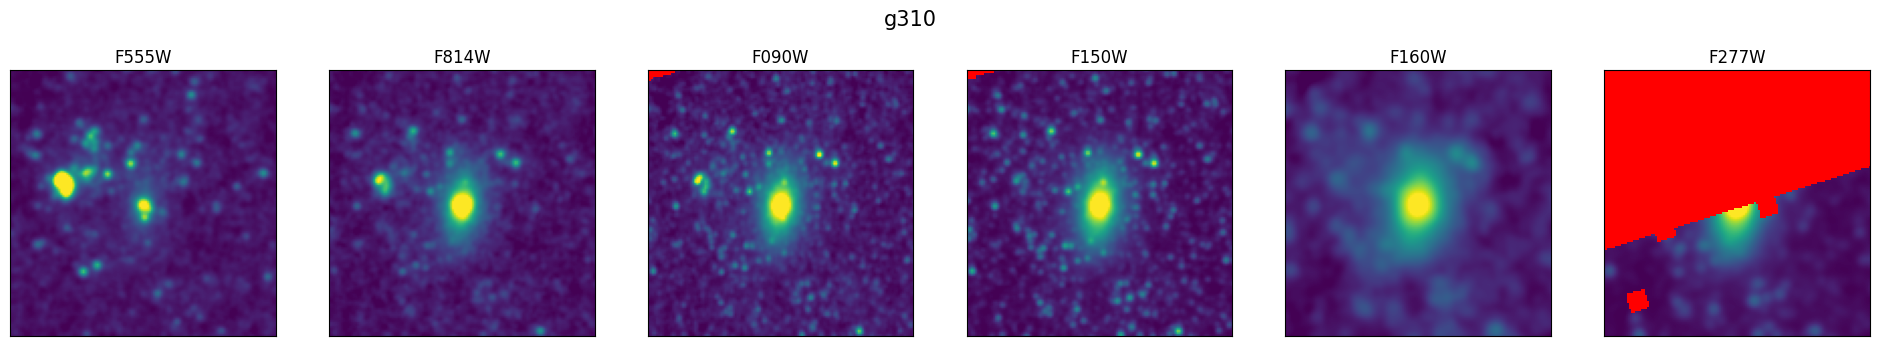

In [5]:
# load PSFs
psfs_data = []
for filtername in filters:
    path = glob.glob(folder_PSF + f'*{filtername}_PSF*.npy')[0]
    psfs_data.append(np.load(path))#
PSFs_dict = dict(zip(filters, psfs_data))

# load data
filepath =  '../sample_data/g310.h5'
galaxy_ID = os.path.splitext(os.path.split(filepath)[-1])[0]
galaxy = load_h5data(filepath, galaxy_ID, filters, PSFs_dict)
galaxy.plot()

# estimate size of the galaxy
base_filter = 'F150W'
filter_obj = galaxy.images[base_filter]
filter_obj.init_size_guess(sigma_guess=10, center_slack = 0.20,
                           plot=True, sigma_kernel=5)

# determine cutout size based on the initial fit
r_eff = filter_obj.size_guess
x0, y0 = filter_obj.x0_guess, filter_obj.y0_guess

cutout_size = r_eff * 6 * 2 # number of pixels in each axis (hence x2)
galaxy_crop = crop_in(galaxy, x0, y0, cutout_size)
galaxy_crop.plot()

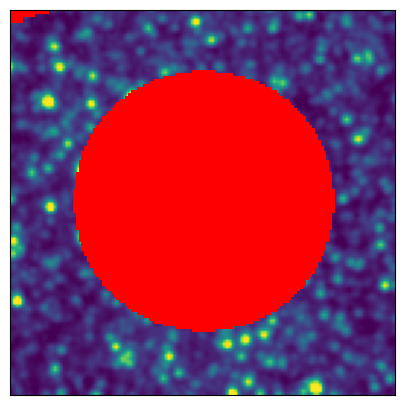

In [19]:
from astropy.modeling import models

# prepare data and psf
filt = 'F150W'
cutoutdata = galaxy_crop.images[filt]

# subtract background
data_annulus = get_data_annulus(cutoutdata._rawdata,4*r_eff,plot=True)
bkg_mean = np.nanmean(data_annulus)
bkg_std = np.nanstd(data_annulus)
cutoutdata.remove_bkg(bkg_mean) # this updates data internally

# prepare model
disk = models.Sersic2D(amplitude=0.1, r_eff=r_eff*5, n=2,
                       x_0=cutout_size/2, y_0=cutout_size/2,
                       ellip=0.2, theta=np.pi/4)
bulge = models.Sersic2D(amplitude=0.5, r_eff=r_eff/5, n=2,
                        x_0=cutout_size/2, y_0=cutout_size/2,
                        ellip=0.2, theta=np.pi/4)
model = SphotModel(disk+bulge, cutoutdata)
model.set_fixed_params({})
model.set_conditions([('r_eff_0','r_eff_1')]) # enforce r_eff_0 >= r_eff_1

# prepare fitter
fitter = ModelFitter(model, cutoutdata.data, 
                     err = np.ones_like(cutoutdata.data)*bkg_std)
bins = np.linspace(-0.5,2,100)


In [22]:
from sphot.fitting import iterative_NM
from scipy.optimize import dual_annealing

In [23]:
# result = dual_annealing(fitter.calc_chi2,x0=x0,args=(),
#                         bounds = fitter.bounds,
#                         maxiter = 10,
#                         initial_temp = 100,
#                         no_local_search = True)
result,success = iterative_NM(fitter.calc_chi2, (), fitter.model.x0, 
                            fitter.bounds,
                            rtol_init=1e-3,rtol_iter=1e-4,
                            rtol_convergence=1e-6,xrtol=1,max_iter=20)

 4.9512e+02 (iter=20: fatol=5.00e-02)   

In [25]:
result,success = iterative_NM(fitter.calc_chi2, (), fitter.model.x0, 
                            fitter.bounds,
                            rtol_init=1e-3,rtol_iter=1e-4,
                            rtol_convergence=1e-6,xrtol=1,max_iter=20)

result = result[0]
for i in range(6):
    np.random.seed(i)
    print('\n performing dual annealing global optimization...')
    result = dual_annealing(fitter.calc_chi2,x0=result.x,args=(),
                            bounds = fitter.bounds,
                            maxiter = 15+i,
                            initial_temp = 10/(i+1),
                            minimizer_kwargs = dict(method='L-BFGS-B',
                                                    bounds=fitter.bounds,
                                                    options=dict(eps=1e-4/(i+1),
                                                                 maxfun=50)))
    
    print('\n performing iterative Nelder-Mead optimization...')
    result, success = iterative_NM(fitter.calc_chi2,x0=result.x,args=(),
                                   bounds = fitter.bounds,
                                   max_iter = 15-i,
                                   xrtol=1e-2/(i+1),
                                   rtol_iter=1e-9/(i+1),
                                   rtol_convergence=1e-10)
    if success:
        break


 performing dual annealing global optimization...
 1.0167e+10    

/Users/sterling/miniconda3/envs/py311/lib/python3.11/site-packages/astropy/modeling/functional_models.py:3336: RuntimeWarning: divide by zero encountered in divide
  z = ((x_maj / r_eff) ** expon + (x_min / b) ** expon) ** inv_expon


 4.9536e+02    

/Users/sterling/miniconda3/envs/py311/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


 4.8095e+02    
 performing iterative Nelder-Mead optimization...
 3.8213e+02 (iter=15: fatol=3.85e-07)   
 performing dual annealing global optimization...
 3.8201e+02    
 performing iterative Nelder-Mead optimization...
 3.4015e+02 (iter=14: fatol=1.71e-07)   
 performing dual annealing global optimization...
 3.3909e+02    
 performing iterative Nelder-Mead optimization...
 3.2402e+02 (iter=13: fatol=1.08e-07)   
 performing dual annealing global optimization...
 3.2260e+02    
 performing iterative Nelder-Mead optimization...
 3.1160e+02 (iter=12: fatol=7.79e-08)   
 performing dual annealing global optimization...
 3.1009e+02    
 performing iterative Nelder-Mead optimization...
 3.0017e+02 (iter=11: fatol=6.01e-08)   
 performing dual annealing global optimization...
 2.9961e+02    
 performing iterative Nelder-Mead optimization...
 2.9086e+02 (iter=10: fatol=4.86e-08)   

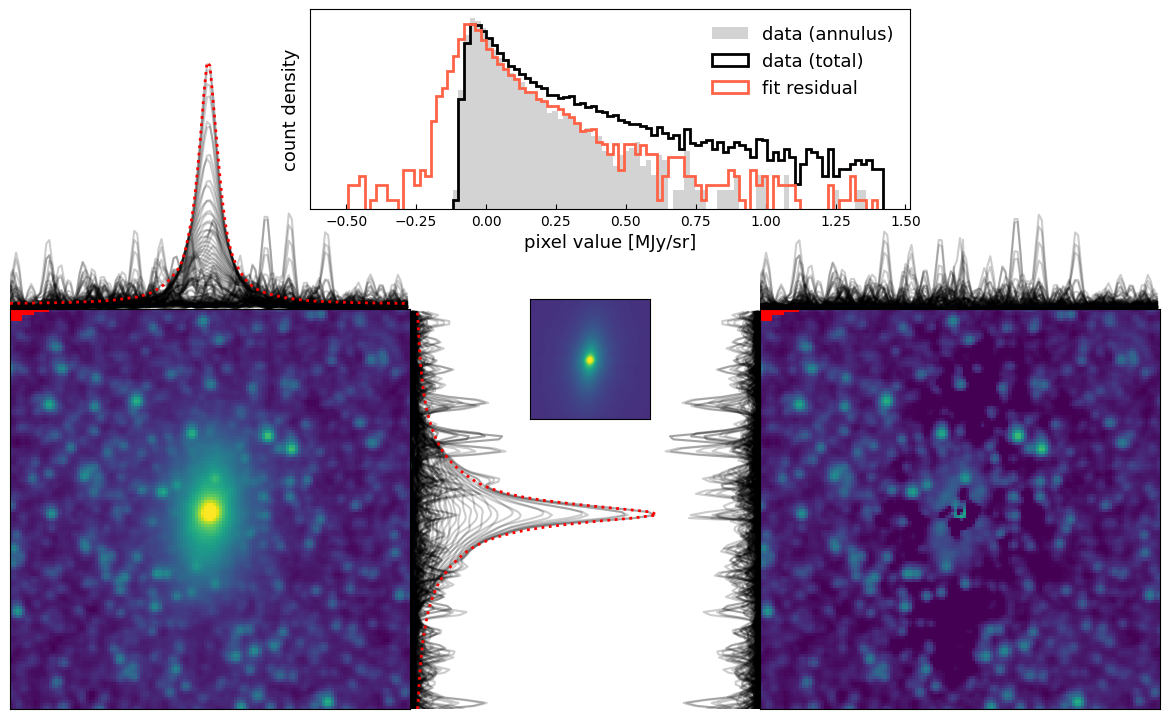

In [33]:
bestfit_sersic_params = result.x
bestfit_img = fitter.eval_model(result.x)
sphot_residual = fitter.data - bestfit_img
plot_sersicfit_result(data = fitter.data,
                      data_annulus = data_annulus - cutoutdata._bkg_level,
                      _img = bestfit_img)

(<matplotlib.colors.LogNorm at 0x17aaeab50>, 0.184393681979037)

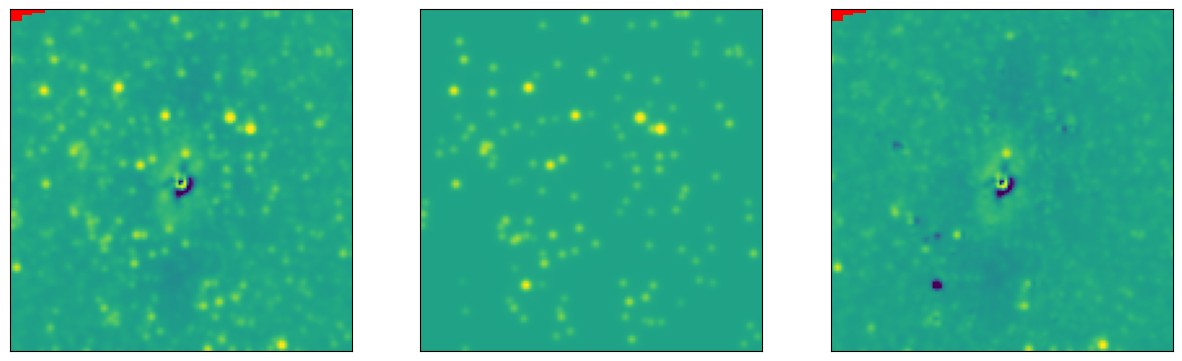

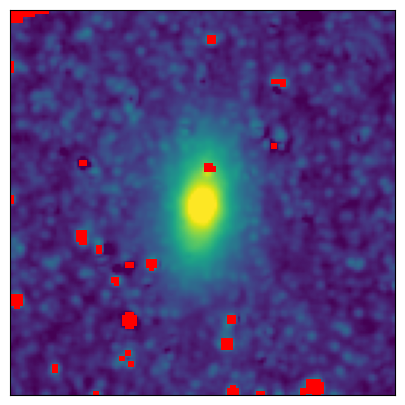

In [50]:
# PSF photometry
from sphot.psf import do_psf_photometry, sigma_clip_outside_aperture
from warnings import filterwarnings
filterwarnings("ignore")
psf_results = do_psf_photometry(sphot_residual, cutoutdata.psf,
                                sigma_psf= fwhm_dict[filt].value/2,
                                psf_oversample=cutoutdata.psf_oversample,
                                psf_blurring=3.5,
                                th=3)
phot_result, psfmodel_img, resid = psf_results

mask = sigma_clip_outside_aperture(resid,r_eff,clip_sigma=5,
                                aper_size_in_r_eff=1,plot=True)
psf_subtracted_data = fitter.data - psfmodel_img
psf_subtracted_data[mask] = np.nan
astroplot(psf_subtracted_data)

 7.6318e+01 (iter=20: fatol=7.64e-03)   

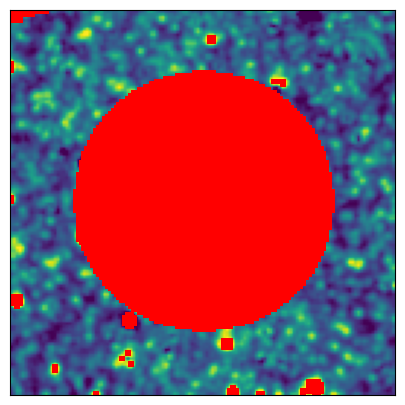

In [53]:
# fit Sersic profile again
# subtract background
data_annulus = get_data_annulus(psf_subtracted_data,4*r_eff,plot=False)
bkg_mean = np.nanmean(data_annulus)
bkg_std = np.nanstd(data_annulus)

# prepare fitter
fitter2 = ModelFitter(model, psf_subtracted_data - bkg_mean, 
                     err = np.ones_like(cutoutdata.data)*bkg_std)

result,success = iterative_NM(fitter2.calc_chi2, (), bestfit_params, 
                            fitter2.bounds,
                            rtol_init=1e-3,rtol_iter=1e-4,
                            rtol_convergence=1e-6,xrtol=1,max_iter=20)
bestfit_sersic_params = result.x

# plot the result
data_annulus = get_data_annulus(cutoutdata._rawdata,4*r_eff,plot=False)
bkg_mean = np.nanmean(data_annulus)
bestfit_img = fitter.eval_model(bestfit_sersic_params)
sphot_residual = fitter.data - bestfit_img
plot_sersicfit_result(data = fitter.data,
                      data_annulus = data_annulus - bkg_mean,
                      _img = bestfit_img)

In [570]:
bestfit_sersic_params = bestfit_params#result.x

100%|██████████| 8/8 [00:49<00:00,  6.17s/it]


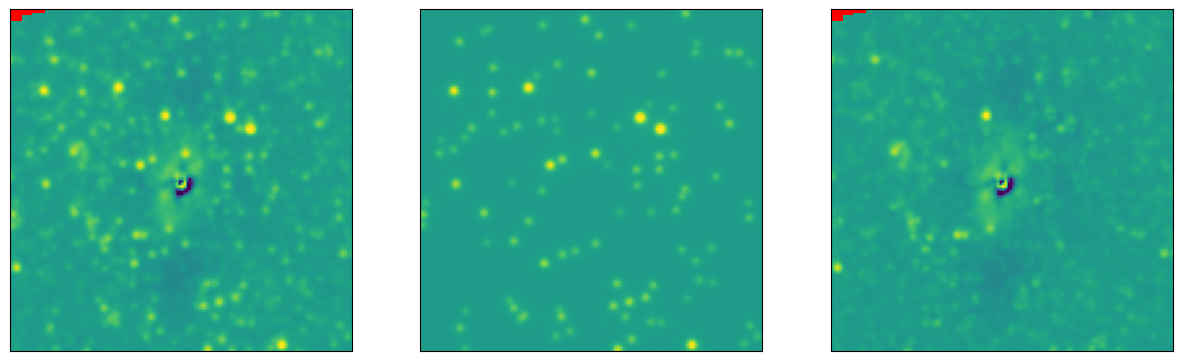

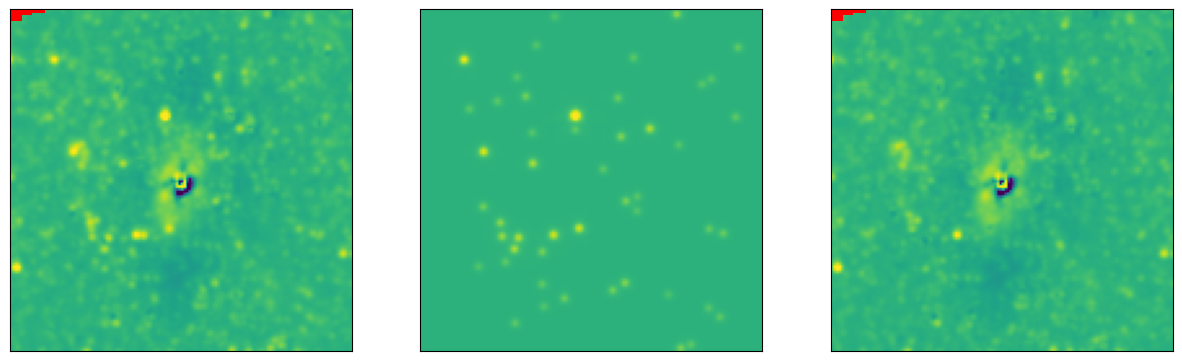

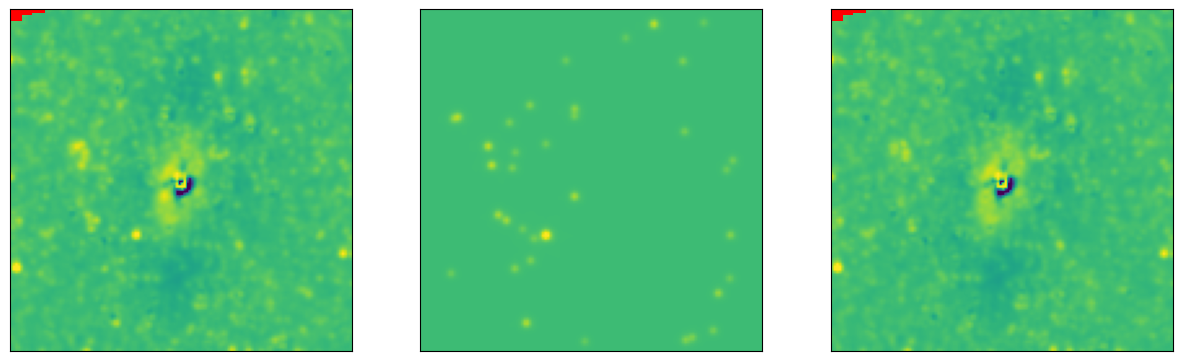

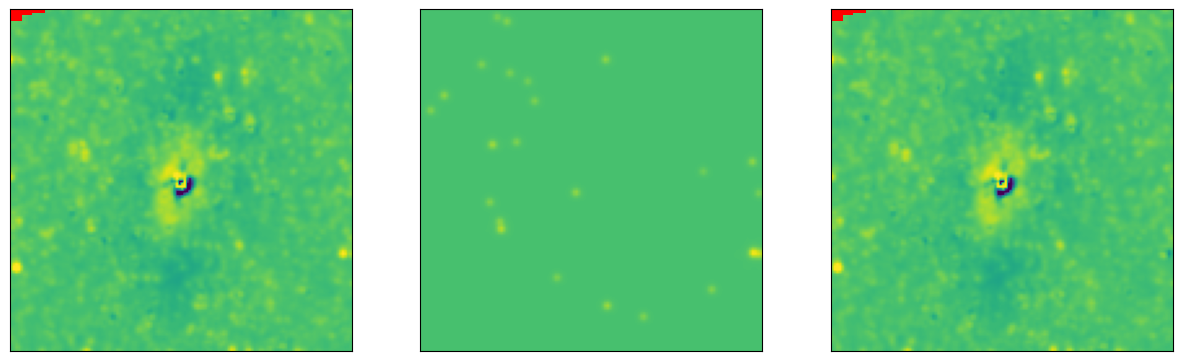

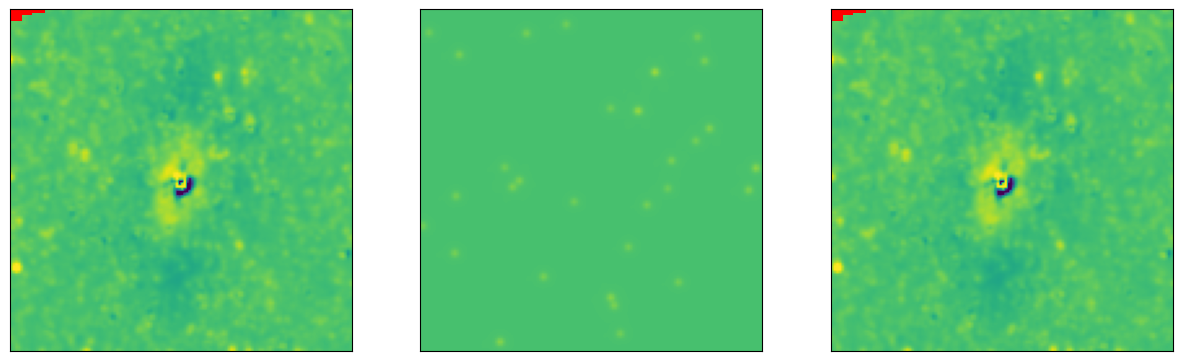

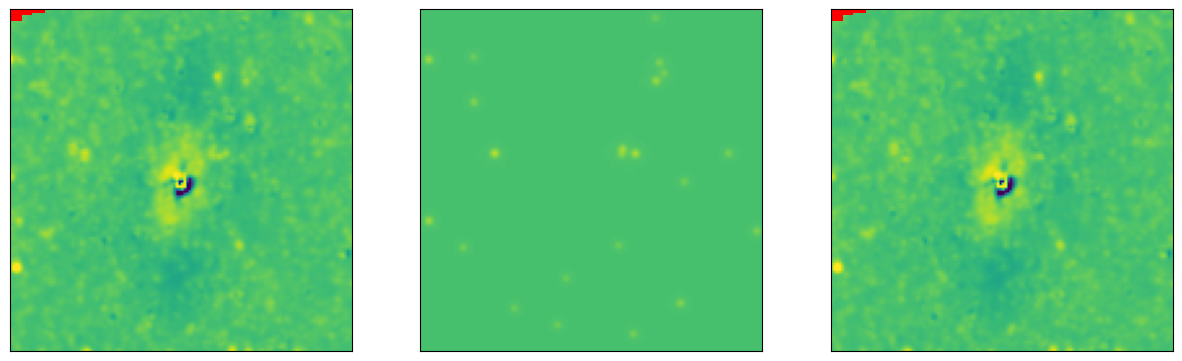

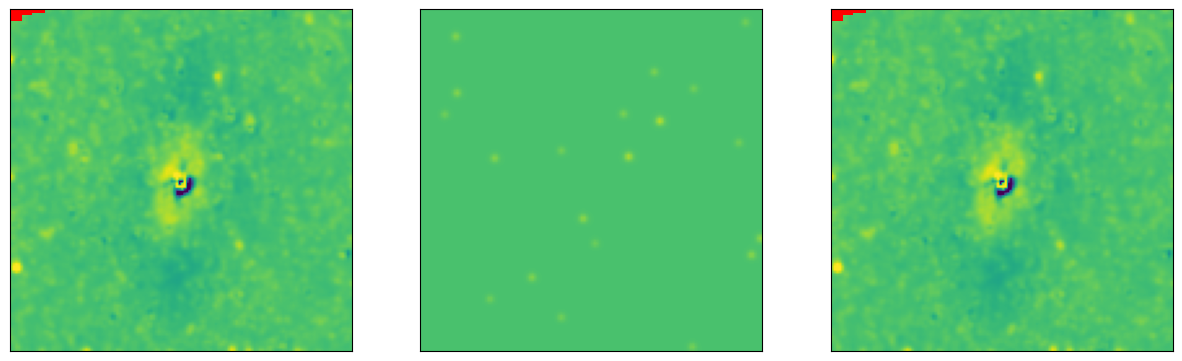

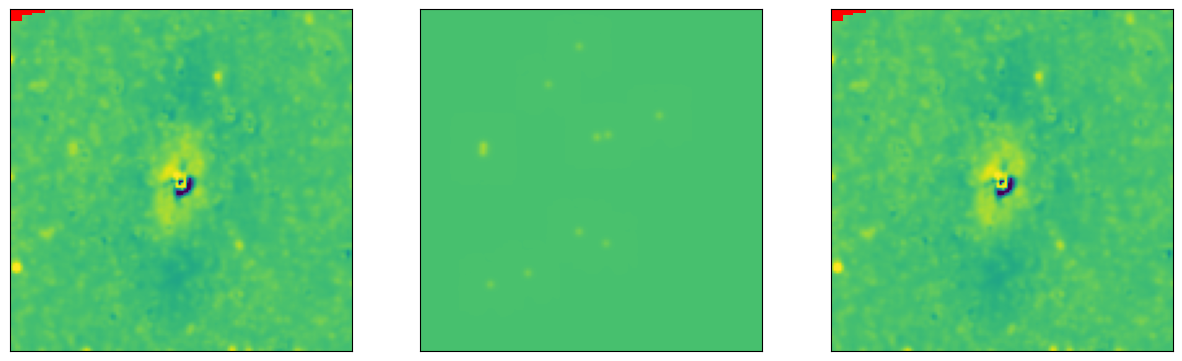

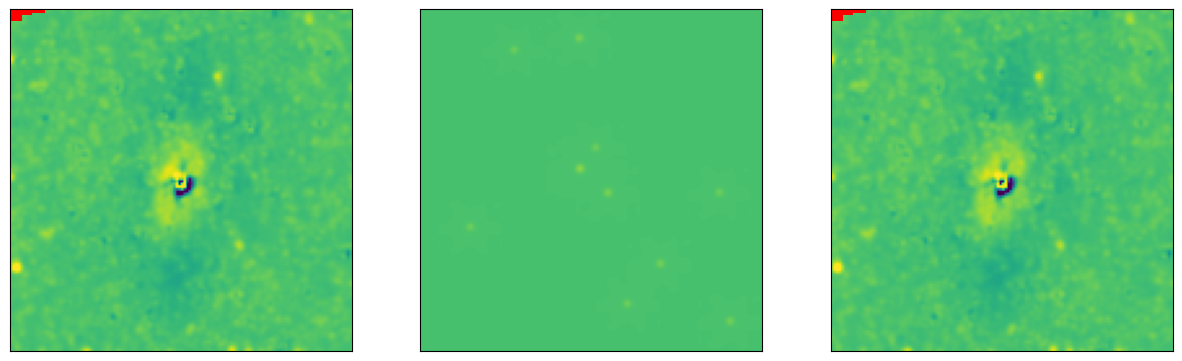

In [156]:
from astropy.table import Table, vstack
from tqdm.auto import tqdm

# sphot result
bestfit_img = fitter.eval_model(result.x)
sphot_residual = fitter.data - bestfit_img

# PSF photometry
psf_results = do_psf_photometry(sphot_residual, cutoutdata.psf,
                                sigma_psf= fwhm_dict[filt].value/2,
                                psf_oversample=cutoutdata.psf_oversample,
                                psf_blurring=3.5,
                                th=3)
phot_result, data_bksub, psfmodel_img, resid = psf_results

# repeat PSF subtraction
threshold_vals = np.arange(1.6,3.2,0.2)[::-1]
for th in tqdm(threshold_vals):
    psf_results = do_psf_photometry(resid, cutoutdata.psf,
                                    sigma_psf= fwhm_dict[filt].value/2,
                                    psf_oversample=cutoutdata.psf_oversample,
                                    psf_blurring=3.5,
                                    th=th)
    if psf_results[0] is not None:
        _phot_result, _, _, resid = psf_results
        phot_result = vstack([phot_result, _phot_result])
    else:
        break

In [579]:
# fit Sersic profile again

# generate PSF-subtracted data
mask = sigma_clip_outside_aperture(resid,r_eff,clip_sigma=5,
                                aper_size_in_r_eff=2,plot=True)
psf_subtracted_data = fitter.data - psf_model_total
psf_subtracted_data[mask] = np.nan

# subtract background (to be consistent)
data_annulus = get_data_annulus(psf_subtracted_data,4*r_eff,plot=False)
bkg_mean = np.nanmean(data_annulus)
bkg_std = np.nanstd(data_annulus)
psf_subtracted_data_bksub = psf_subtracted_data - bkg_mean
psf_subtracted_data_bksub_error = np.ones_like(psf_subtracted_data)*bkg_std
# # prepare fitter
# fitter2 = ModelFitter(model, psf_subtracted_data - bkg_mean, 
#                      err = np.ones_like(cutoutdata.data)*bkg_std)

# result,success = iterative_NM(fitter2.calc_chi2, (), bestfit_params, 
#                             fitter2.bounds,
#                             rtol_init=1e-3,rtol_iter=1e-4,
#                             rtol_convergence=1e-6,xrtol=1,max_iter=20)

In [423]:
from sphot.plotting import plot_profile2d

Text(0.2, 0.88, 'E: A-D')

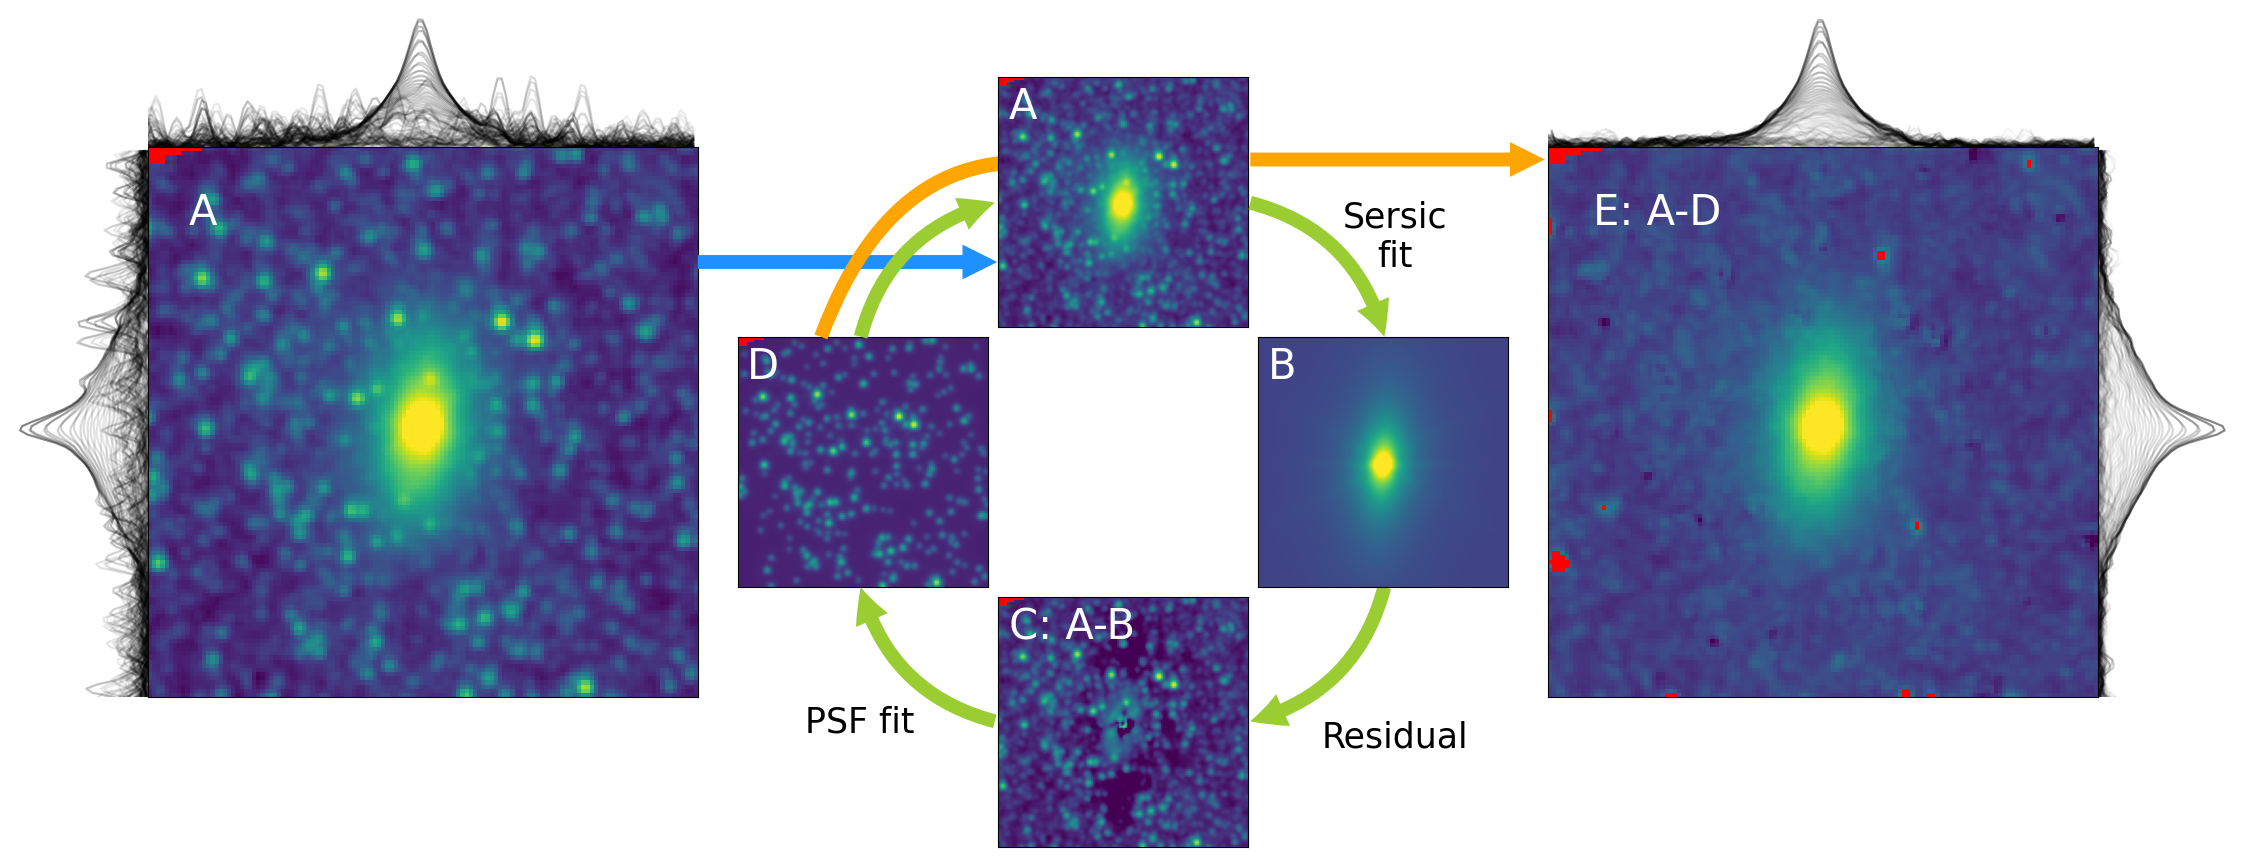

In [568]:
psf_model_total = sphot_residual - resid

# mask off bad pixels
mask = sigma_clip_outside_aperture(resid,r_eff,clip_sigma=5,
                                aper_size_in_r_eff=2,plot=True)
resid_masked = resid.copy()
resid_masked[mask] = np.nan

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_axes([-0.45,0.55,0.55,0.55])
ax4 = fig.add_axes([0.14,0.66,0.25,0.25])
ax3 = fig.add_axes([0.4,0.4,0.25,0.25])
ax2 = fig.add_axes([0.66,0.66,0.25,0.25])
ax1 = fig.add_axes([0.4,0.92,0.25,0.25])
ax5 = fig.add_axes([0.95,0.55,0.55,0.55])

cmap='viridis'
norm,offset = astroplot(fitter.data,ax=ax1,percentiles=[0,99.5],cmap=cmap)
plot_profile2d(fitter.data,ax0,fig,cmap=cmap,left=True,norm=norm,offset=offset)
astroplot(bestfit_img,ax=ax2,norm=norm,offset=offset,cmap=cmap)
astroplot(sphot_residual,ax=ax3,norm=norm,offset=offset,cmap=cmap)
astroplot(psf_model_total,ax=ax4,norm=norm,offset=offset,cmap=cmap)
plot_profile2d(psf_subtracted_data_bksub,ax5,fig,cmap=cmap,norm=norm,offset=offset)

arrowprops0 = dict(arrowstyle="simple",lw=0,fc='dodgerblue')
arrowprops1 = dict(arrowstyle="simple",connectionstyle="arc3,rad=-0.3",
                   lw=0,fc='yellowgreen')
arrowprops2 = dict(arrowstyle="simple",connectionstyle="arc3,rad=-0.55",
                   lw=0,fc='orange')
arrowprops3 = dict(arrowstyle="simple",lw=0,fc='orange')
arrow_kwargs = dict(
    xycoords='axes fraction',
    textcoords='axes fraction',
    size=50, va="center", ha="center",
)
ax4.annotate("",xy=(1.05,1.3), xytext=(-0.17,1.3), arrowprops=arrowprops0,zorder=0,**arrow_kwargs)
ax1.annotate("",xy=(0,0.5), xytext=(-0.55,-0.05), arrowprops=arrowprops1,**arrow_kwargs)
ax1.annotate("",xy=(1.55,-0.05), xytext=(1.0,0.5), arrowprops=arrowprops1,**arrow_kwargs)
ax3.annotate("",xy=(1.0,0.5), xytext=(1.55,1.05), arrowprops=arrowprops1,**arrow_kwargs)
ax3.annotate("",xy=(-0.55,1.05), xytext=(0,0.5), arrowprops=arrowprops1,**arrow_kwargs)
ax4.annotate("",xy=(1.7,1.55), xytext=(0.33,0.99), arrowprops=arrowprops2, **arrow_kwargs)
ax1.annotate("",xy=(2.2,0.67), xytext=(1.0,0.67), arrowprops=arrowprops3, zorder=10,**arrow_kwargs)
ax2.annotate('Sersic\nfit',xy=(0.55,1.4), xycoords='axes fraction', ha='center', va='center', fontsize=25)
ax2.annotate('Residual',xy=(0.55,-0.6), xycoords='axes fraction', ha='center', va='center', fontsize=25)
ax3.annotate('PSF fit',xy=(-0.55,0.5), xycoords='axes fraction', ha='center', va='center', fontsize=25)

ax0.text(0.1,0.88,'A',transform=ax0.transAxes,ha='center',va='center',fontsize=30,color='w')
ax1.text(0.1,0.88,'A',transform=ax1.transAxes,ha='center',va='center',fontsize=30,color='w')
ax2.text(0.1,0.88,'B',transform=ax2.transAxes,ha='center',va='center',fontsize=30,color='w')
ax3.text(0.3,0.88,'C: A-B',transform=ax3.transAxes,ha='center',va='center',fontsize=30,color='w')
ax4.text(0.1,0.88,'D',transform=ax4.transAxes,ha='center',va='center',fontsize=30,color='w')
ax5.text(0.2,0.88,'E: A-D',transform=ax5.transAxes,ha='center',va='center',fontsize=30,color='w')

(<matplotlib.patches.Ellipse at 0x2e8211dd0>,)

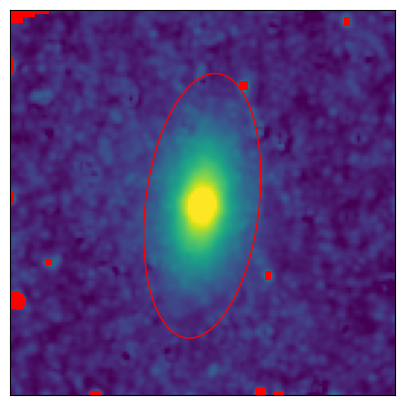

In [580]:
from photutils.aperture import EllipticalAperture, aperture_photometry

# prepare parameters from Sersic profile fit
bestfit_sersic_params_physical = dict(zip(fitter.model.free_params,
                                          fitter.unstandardize_params(bestfit_sersic_params)))
x_0 = bestfit_sersic_params_physical['x_0']
y_0 = bestfit_sersic_params_physical['y_0']
r_eff_disk = bestfit_sersic_params_physical['r_eff_0']
ellip_disk = bestfit_sersic_params_physical['ellip_0']
theta_disk = bestfit_sersic_params_physical['theta_0']
b = (1 - ellip_disk) * r_eff_disk

# perform aperture photometry
aperture_size = 2
ellip_aperture = EllipticalAperture((x_0, y_0), aperture_size*r_eff_disk, aperture_size*b, theta=theta_disk)
phot_table = aperture_photometry(psf_subtracted_data_bksub,ellip_aperture,psf_subtracted_data_bksub_error)

# plot
fig,ax = plt.subplots(1,1,figsize=(5,5))
astroplot(psf_subtracted_data_bksub,ax=ax)
ellip_aperture.plot(ax=ax,color='r')

In [588]:
def calc_mag(total_counts_Mjy_per_Sr,error_Mjy_per_Sr):
    PIXAR_SR = ((0.03*u.arcsec)**2).to(u.sr).value
    magAB = -6.10 - 2.5 *np.log10(total_counts_Mjy_per_Sr*PIXAR_SR)
    magAB_err = 2.5/np.log(10) * error_Mjy_per_Sr/total_counts_Mjy_per_Sr
    return magAB,magAB_err

In [585]:
phot_table

<QTable length=1>
  id       xcenter           ycenter         aperture_sum     aperture_sum_err
             pix               pix                                            
int64      float64           float64           float64            float64     
----- ----------------- ----------------- ------------------ -----------------
    1 65.40868768461077 64.36787871221128 1672.2704114993908 1.438226751671107

In [589]:
# from sphot.data import calc_mag
counts_sum = phot_table['aperture_sum'].value[0]
counts_err = phot_table['aperture_sum_err'].value[0]
calc_mag(counts_sum,counts_err)

(20.028253128296754, 0.0009337813096512885)

In [ ]:
phot_table = aperture_photometry(data, aperture, error=error)